In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2)*out.grad
        out._backward = _backward    
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'; L.grad = 1.0
L


Value(data=-8.0)

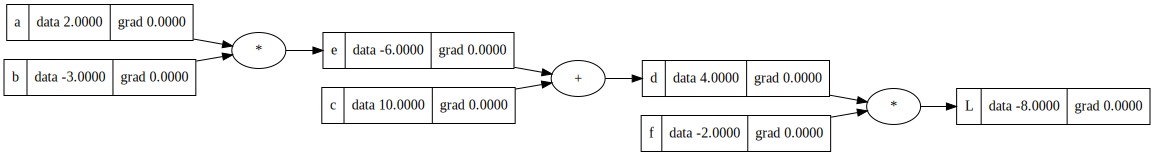

In [38]:
from graphviz import Digraph

def trace(root):
    # 辅助函数：遍历整个计算图，收集所有的点(nodes)和边(edges)
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n)) # 获取每个节点在内存中的唯一ID
        
        # 1. 为每个 Value 对象画一个矩形框
        # 显示内容：label | data | grad
        # %.4f 表示保留4位小数
        # 使用 getattr 防止旧的 Value 实例缺少属性导致 AttributeError
        display_label = "{ %s | data %.4f | grad %.4f}" % (getattr(n, 'label', ''), getattr(n, 'data', 0.0), getattr(n, 'grad', 0.0))
        
        dot.node(name=uid, label=display_label, shape='record')
        
        # 2. 如果这个节点是通过运算产生的（有 _op），就多画一个圆形的操作符节点
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            # 把操作符和结果连起来
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # 3. 连接输入节点和操作符
        # 如果 n2 是由运算产生的，连到它的操作符节点上
        # 否则直接连到 n2 上
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
draw_dot(L)